In [1]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import time
import requests
from tqdm.notebook import tqdm

from mpl_toolkits.mplot3d import Axes3D

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.10.0


## I. CONFIGURATIONS

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


## II. READ DATA

In [4]:
# WEB SCRAPING using the following website : loto.akroweb.fr
def scrap_loto_numbers():
    my_list=[]
    time.sleep(2)
    loto_url = "http://loto.akroweb.fr/loto-historique-tirages/"
    page = requests.get(loto_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    body = soup.find('table')
    tirage_line = body.find_all('tr')
    for value in tirage_line:
        my_dict = {}
        res = value.text.split('\n')
        for i,val in enumerate(res[5:10]):
            my_dict['num'+str(i)]=int(val)
        my_dict['chance']=int(res[10])
        my_list.append(my_dict)
    df=pd.DataFrame(my_list)
    return df

In [5]:
# Web scraping for the current historique
lotto_scrapped=scrap_loto_numbers()
lotto_scrapped[['num0','num1','num2','num3','num4','chance']].head()

# Invert the dataframe so the last game is in last position. 
lotto = lotto_scrapped.iloc[::-1]
lotto = lotto[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']] #sélection des numéros à  traiter
lotto

,num0,num1,num2,num3,num4,chance
2342,19,24,27,33,41,9
2341,22,24,32,41,48,1
2340,10,20,22,39,46,4
2339,10,11,37,41,48,4
2338,18,20,28,40,49,1
...,...,...,...,...,...,...
4,2,8,11,40,47,7
3,3,8,18,25,37,6
2,22,33,37,42,43,4
1,11,17,20,28,36,10


## III. EXPLORING DATA

In [6]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 7 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [7]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [8]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [9]:
nRowsRead = 'None' # specify 'None' if want to read whole file, else the number of rows you want to read
# lotto_history.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = lotto
df1.dataframeName = 'lotto_history.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2343 rows and 6 columns


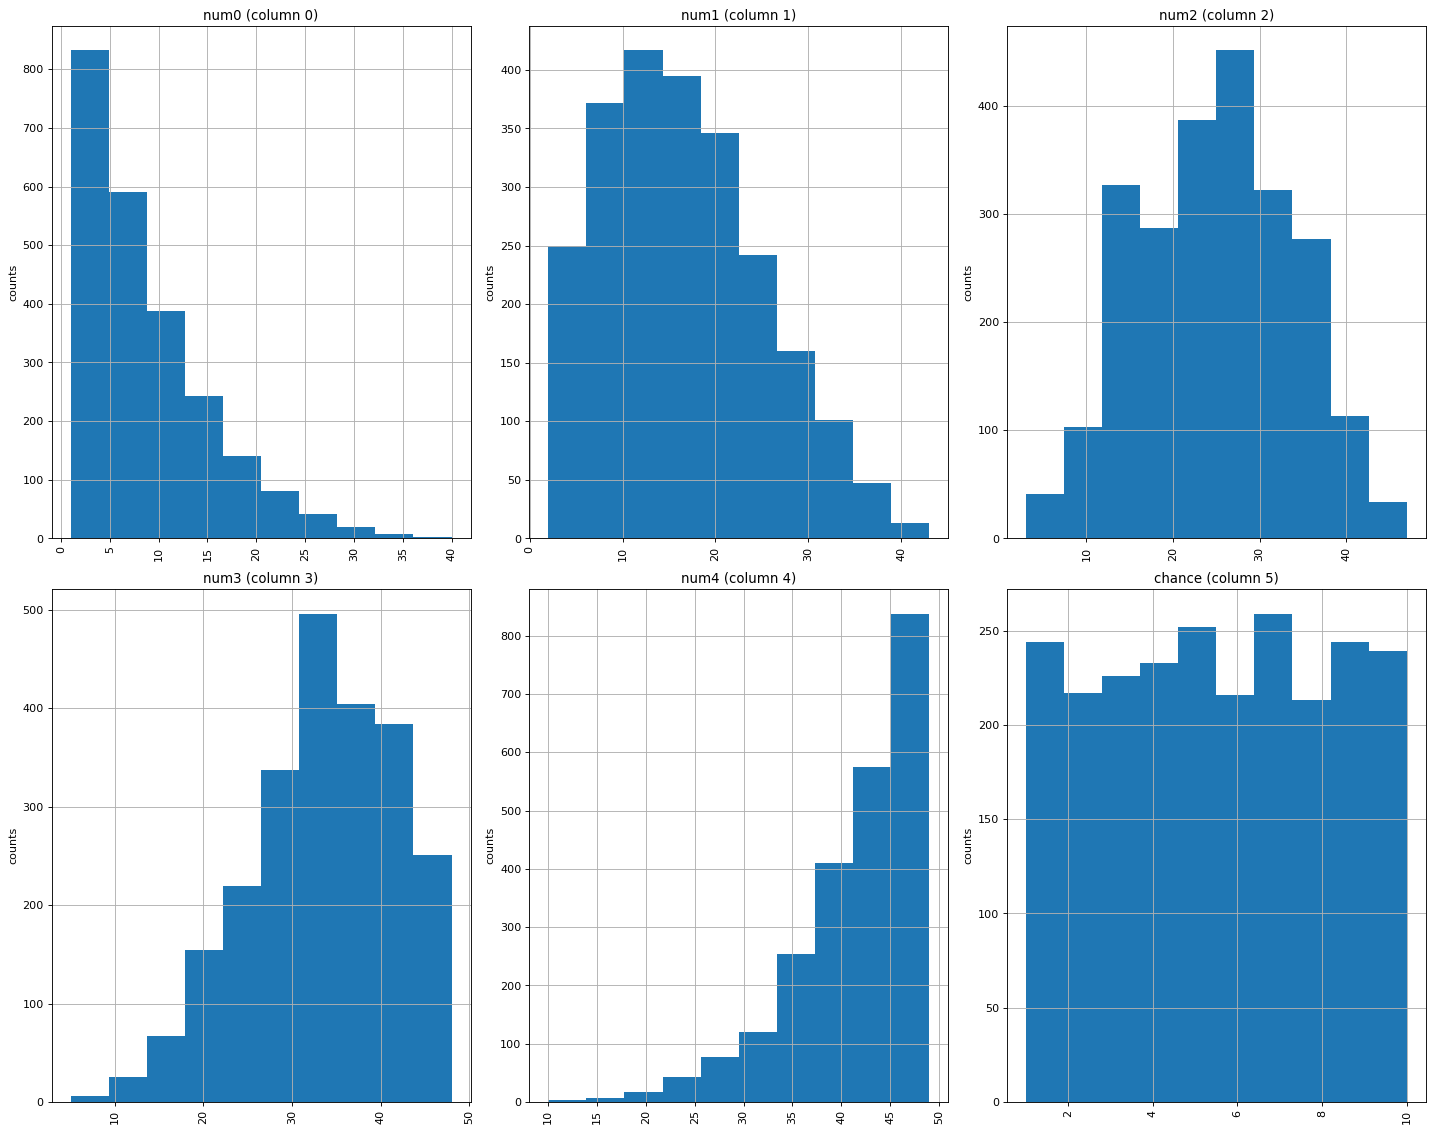

In [10]:
# Distribution graphs (histogram/bar graph) of sampled columns:
plotPerColumnDistribution(df1, 10, 3)

C:\Users\Olivi\AppData\Local\Temp\ipykernel_24960\3510424060.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


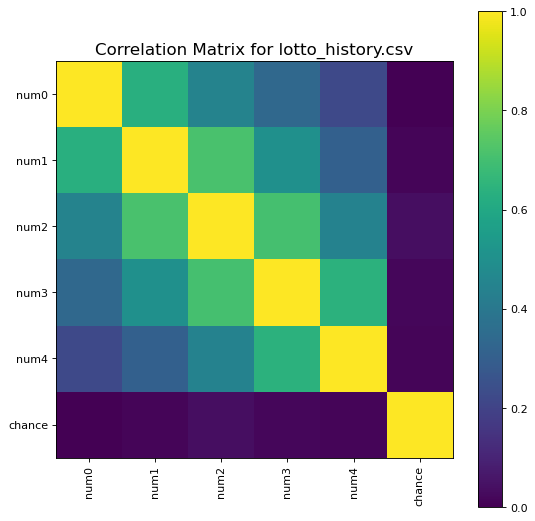

In [11]:
# Correlation Matrix
plotCorrelationMatrix(df1, 8)

C:\Users\Olivi\AppData\Local\Temp\ipykernel_24960\102845399.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


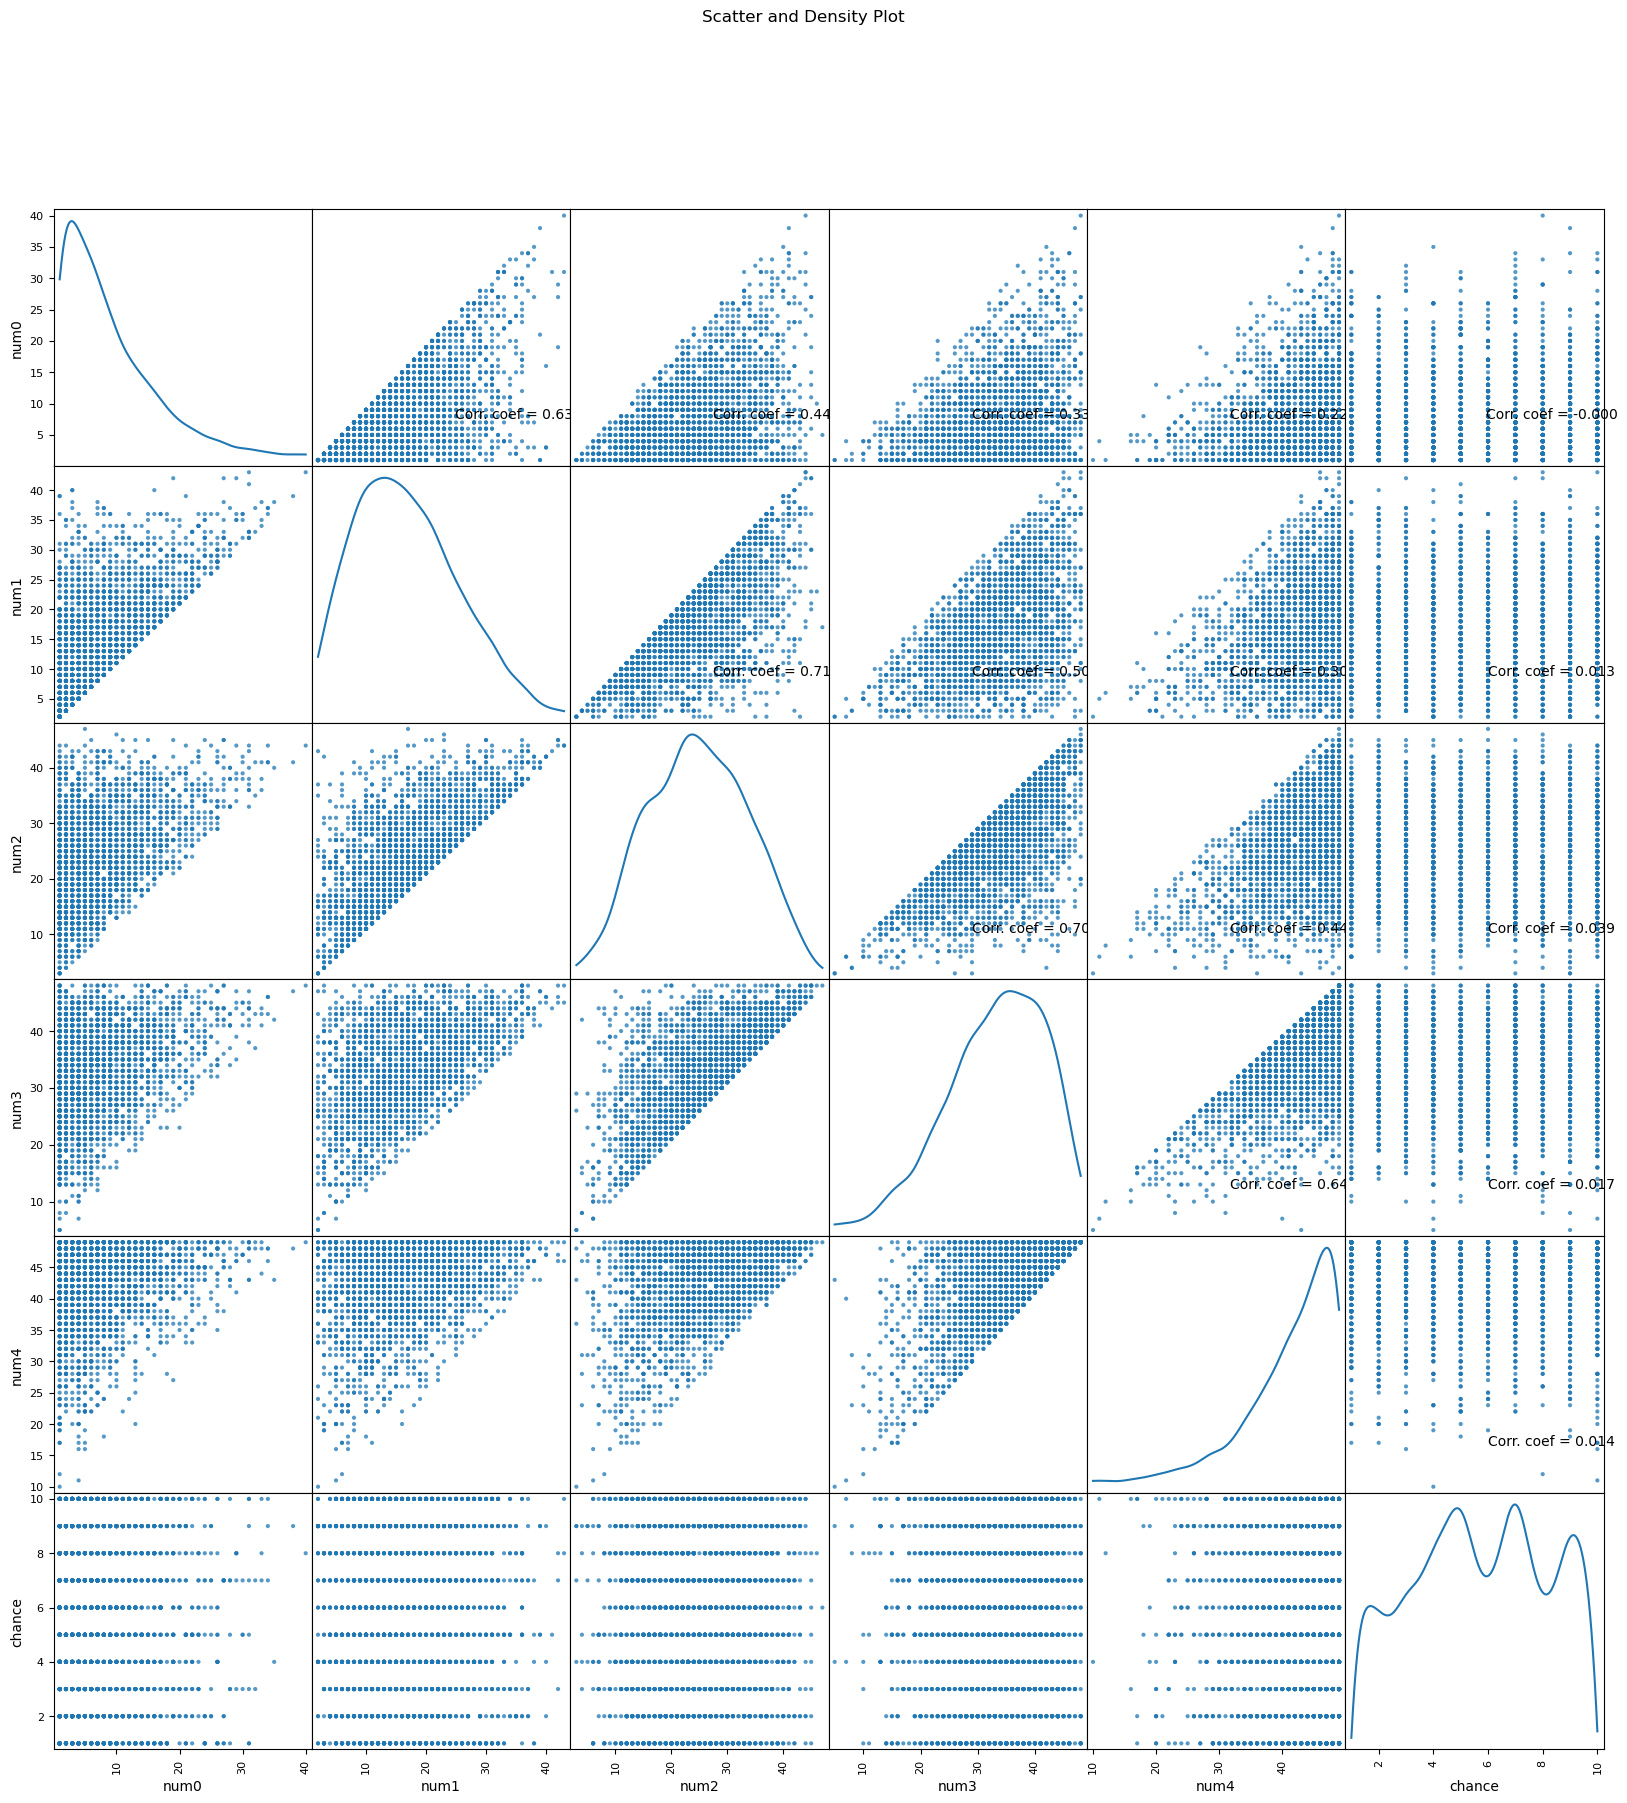

In [12]:
# Scatter and Density plots
plotScatterMatrix(df1, 20, 10)

## IV. TRAIN TEST SPLIT

In [13]:
# Use the last 50 draws (nbDrawsToTake) as the test dataset Use a sliding window (w) of 10 to split the input data


In [14]:
nbDrawsToTake = int(round(nRow*0.3,0))
# nbDrawsToTake = 50

data = lotto.values - 1
train = data[:-nbDrawsToTake]
test = data[-nbDrawsToTake:]

# Sliding window "w"
w = 50 #10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test


In [15]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2343, 6)
(1590, 50, 6)
(1590, 6)
(703, 50, 6)
(703, 6)


## V. Seq2Seq Model to Predict Future Draws

In [16]:
# Input the last 10 draws and sequentially predict the next draw. 
# Monitor the performance by sparse categorical crossentropy and sparse top k categorical accuracy.

In [17]:
embed_dim = 2*((59 // 2) + 1)
dropout_rate = 0.5 #0.5
spatial_dropout_rate = 0.5 #0.5
steps_before = w
steps_after = 6
feature_count = embed_dim * 6
hidden_neurons = [64, 32] 
bidirectional = True 
attention_style = 'Bahdanau'

In [18]:
with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    # Embed 59 categories into a 30-dimension continuous-number vector for each ball
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(59, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(59, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(59, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)
    
    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(59, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(59, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)    
    
    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(59, embed_dim)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)
    
    
    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6])
    
    
    
    # Seq2Seq model with attention or bidirectional encoder
    num_layers = len(hidden_neurons)
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        for i in range(num_layers):
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    else:
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
    else:
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        decoder = concatenate([context, decoder])
    
    out = Dense(59, activation = 'softmax')(decoder)
    model = Model(inputs = inp0, outputs = out)
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])

In [19]:
#model.summary()

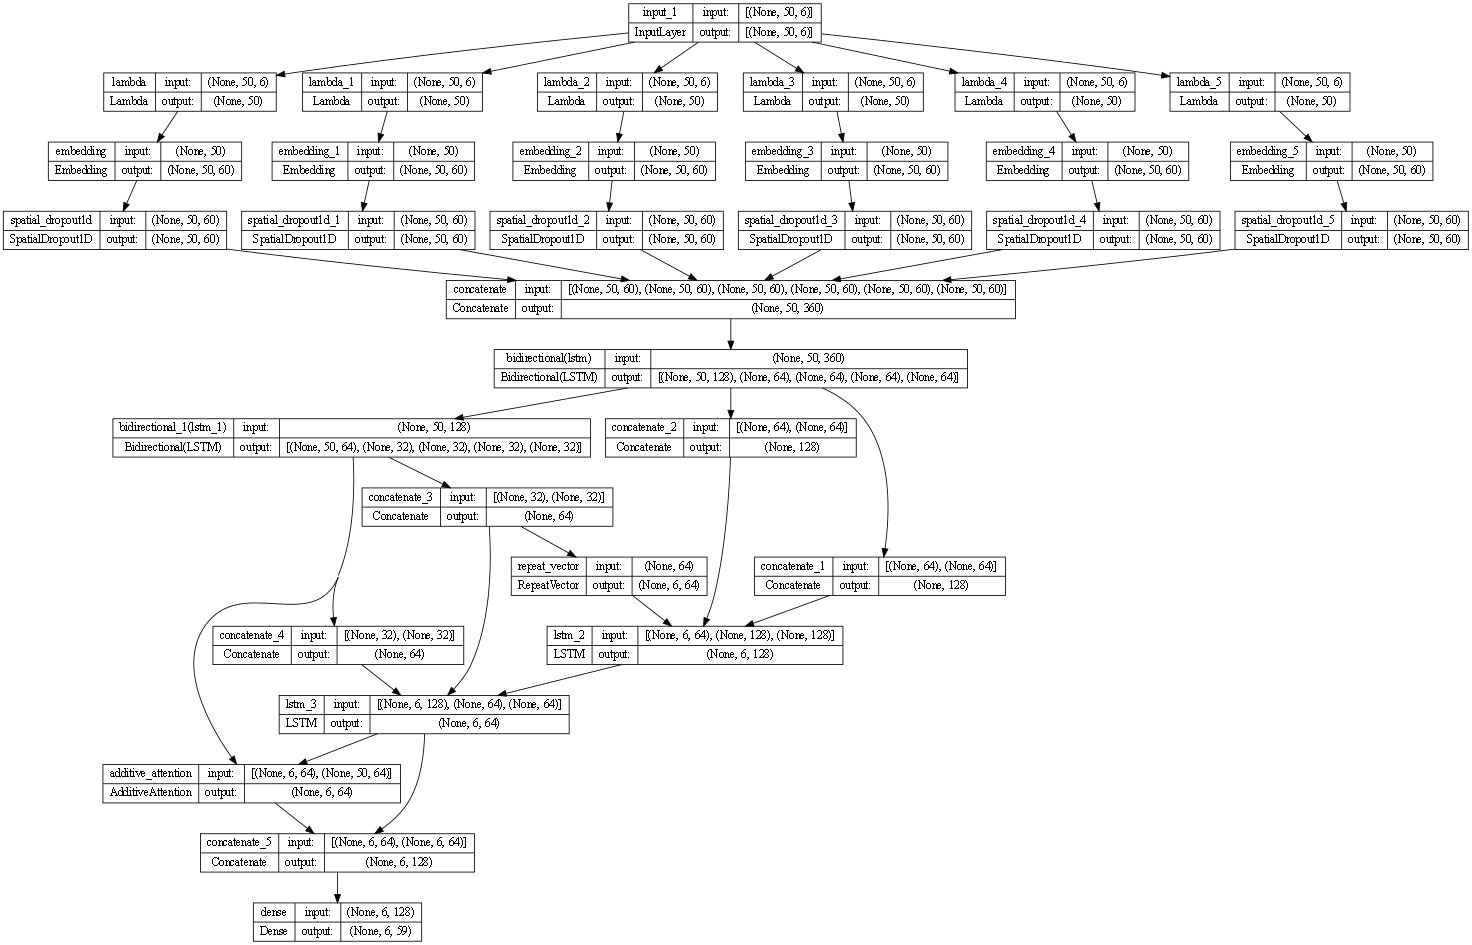

In [20]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)

In [21]:
class CosineAnnealingScheduler(callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [22]:
EPOCHS = 40 #50
BATCH_SIZE = 16
LR_MAX = 1e-4
LR_MIN = 1e-10 #e-7

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/40
100/100 - 22s - loss: 4.0469 - sparse_top_k: 0.1325 - val_loss: 3.9452 - val_sparse_top_k: 0.1676 - lr: 1.0000e-04 - 22s/epoch - 220ms/step
Epoch 2/40
100/100 - 7s - loss: 3.8528 - sparse_top_k: 0.1689 - val_loss: 3.7722 - val_sparse_top_k: 0.1648 - lr: 9.9846e-05 - 7s/epoch - 69ms/step
Epoch 3/40
100/100 - 8s - loss: 3.7214 - sparse_top_k: 0.1812 - val_loss: 3.6519 - val_sparse_top_k: 0.1987 - lr: 9.9384e-05 - 8s/epoch - 81ms/step
Epoch 4/40
100/100 - 8s - loss: 3.6141 - sparse_top_k: 0.2289 - val_loss: 3.5645 - val_sparse_top_k: 0.2276 - lr: 9.8618e-05 - 8s/epoch - 80ms/step
Epoch 5/40
100/100 - 8s - loss: 3.5341 - sparse_top_k: 0.2723 - val_loss: 3.4824 - val_sparse_top_k: 0.2556 - lr: 9.7553e-05 - 8s/epoch - 79ms/step
Epoch 6/40
100/100 - 8s - loss: 3.4664 - sparse_top_k: 0.2974 - val_loss: 3.4225 - val_sparse_top_k: 0.2926 - lr: 9.6194e-05 - 8s/epoch - 79ms/step
Epoch 7/40
100/100 - 8s - loss: 3.4085 - sparse_top_k: 0.3102 - val_loss: 3.3654 - val_sparse_top_k: 0.2928 -

0.3181602656841278


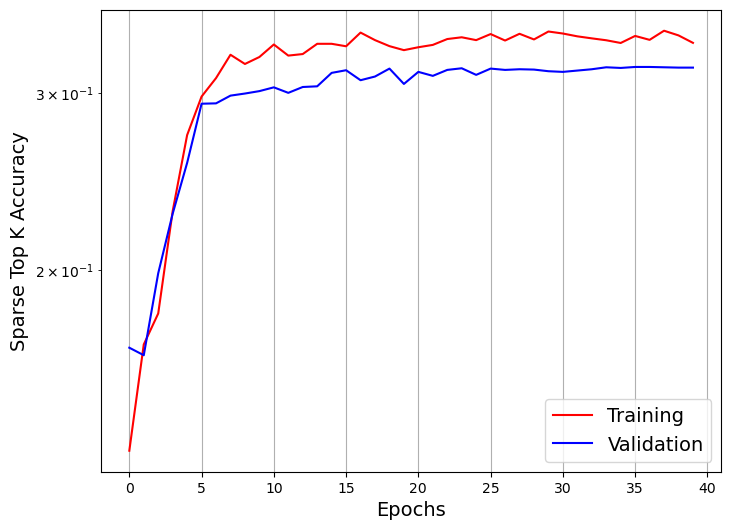

In [23]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

## VI. ANALYSIS PREDICTION

In [24]:
model.load_weights('best_model.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

22/22 [==============================] - 2s 21ms/step


In [25]:
cnt_element_with_1_good_element = 0
cnt_element_with_2_good_element = 0
cnt_element_with_3_good_element = 0
cnt_element_with_4_good_element = 0
cnt_element_with_5_good_element = 0
cnt_element_with_6_good_element = 0
cnt_total = 0
list_list_intersection = []
list_list_intersection_chance = []


for i in range(y_test.shape[0]):
#     print('Prediction:\t', pred[i] + 1)
#     print('Truth:     \t', y_test[i] + 1)

    list_intersection = list(set(pred[i][0:5]+1) & set(y_test[i][0:5]+1))
    list_intersection_chance = list(set(pred[i][5:6]+1) & set(y_test[i][5:6]+1))
    nbr_elementList = len(list_intersection)
    nbr_elementList_chance = len(list_intersection_chance)
    nbr_elementList_chance_sum = nbr_elementList + nbr_elementList_chance
    
    list_list_intersection = np.append(list_list_intersection, list_intersection)
    list_list_intersection_chance = np.append(list_list_intersection_chance, list_intersection_chance)
    
#     print("Number of correct numbers : %(nb)s" % {'nb': nbr_elementList})
#     print("Number of correct chance number : %(nb)s" % {'nb': nbr_elementList_chance})
    
#     if nbr_elementList > 0: 
#         cnt_total = cnt_total+1
#     else: 
#         cnt_total = cnt_total+1

#     if nbr_elementList > 0:
# #         print("Correct numbers : %(li)s" % {'li': list_intersection})
#     else:
# #         print("NO Correct numbers")
#         print(" ")
#     if nbr_elementList_chance > 0:
# #         print("Correct chance number : %(li)s" % {'li': list_intersection_chance})
#     else:
# #         print("NO Correct Chance number")      

            
    if nbr_elementList_chance_sum > 0 and nbr_elementList_chance_sum <=1:
        cnt_element_with_1_good_element = cnt_element_with_1_good_element + 1
    elif nbr_elementList_chance_sum > 1 and nbr_elementList_chance_sum <=2:
        cnt_element_with_2_good_element = cnt_element_with_2_good_element + 1
    elif nbr_elementList_chance_sum > 2 and nbr_elementList_chance_sum <=3:
        cnt_element_with_3_good_element = cnt_element_with_3_good_element + 1
    elif nbr_elementList_chance_sum > 3 and nbr_elementList_chance_sum <=4:
        cnt_element_with_4_good_element = cnt_element_with_4_good_element + 1
    elif nbr_elementList_chance_sum > 4 and nbr_elementList_chance_sum <=5:
        cnt_element_with_5_good_element = cnt_element_with_5_good_element + 1
    elif nbr_elementList_chance_sum > 5 and nbr_elementList_chance_sum <=6:
        cnt_element_with_6_good_element = cnt_element_with_6_good_element + 1
    else:
        cnt_total = cnt_total+1
    
#     print('-' * 40)



In [26]:
# Count the frequency of each element for the prediction

from collections import Counter
frequency_count_NUM = list(Counter(list_list_intersection).items())
frequency_count_NUM_CHANCE = list(Counter(list_list_intersection_chance).items())


In [27]:
# Create a temporary dataframe containing the truth and prediction
df = pd.DataFrame()
pred = pred+1
y_test = y_test+1
df['Truth NUM'] = y_test.tolist()
df['Prediction'] = pred.tolist()

# We want to divide the truth column into two columns containing : 1. the first 5 numbers and 2. the lucky number.
# We copy the column
df['Truth NUM CHANCE'] = df['Truth NUM']
# # We remove the first 5 element of each sublist 
df['Truth NUM CHANCE'] = df['Truth NUM CHANCE'].apply(lambda x: x[5:])
# # We remove the last element of each sublist 
df['Truth NUM'] = df['Truth NUM'].apply(lambda x: x[:-1])

#Finally we repositionate the columns in the good order for visualisation purposes
desired_order = ['Truth NUM', 'Truth NUM CHANCE', 'Prediction']
df = df[desired_order]

In [28]:
from collections import Counter
## COMPUT NUM FREQUENCY FOR TRUTH
## Flatten a list of list to a single flat list
Truth_list = df['Truth NUM'].tolist()
flat_Truth_list = [item for sublist in Truth_list for item in sublist]
## Compute the frequency of each number from 1 to 49. 
freq_truth = []
for i in range(49):
    freq_truth.append(flat_Truth_list.count(i))
freq_truth = freq_truth[1:49]


## COMPUT NUM CHANCE FREQUENCY FOR TRUTH
## Flatten a list of list to a single flat list
Truth_list_chance = df['Truth NUM CHANCE'].tolist()
flat_Truth_list_chance = [item for sublist in Truth_list_chance for item in sublist]
## Compute the frequency of each number from 1 to 49. 
freq_truth_chance = []
for i in range(10):
    freq_truth_chance.append(flat_Truth_list_chance.count(i))
freq_truth_chance = freq_truth_chance[1:10]
freq_truth_chance


# ADD resutt to anothers dataframe
df_freq = pd.DataFrame()
df_freq_chance = pd.DataFrame()

df_freq['freq_truth'] = freq_truth
df_freq["freq_NUM"] = np.nan
df_freq_chance['freq_truth_CHANCE'] = freq_truth_chance
df_freq_chance["freq_NUM_CHANCE"] = np.nan
df_freq.index = np.arange(1, len(df_freq) + 1)
df_freq_chance.index = np.arange(1, len(df_freq_chance) + 1)


# frequency_count

In [29]:
# df_freq_chance

# Iterate over each row in the dataframe
for index, row in df_freq_chance.iterrows():
    # Check if the index exists in the list
    if any(item[0] == index for item in frequency_count_NUM_CHANCE):
        # Get the corresponding frequency from the list
        frequency = next(item[1] for item in frequency_count_NUM_CHANCE if item[0] == index)
        # Assign the frequency to the new column
        df_freq_chance.at[index, 'freq_NUM_CHANCE'] = frequency
df_freq_chance = df_freq_chance.dropna()
df_freq_chance = df_freq_chance.reset_index()

# Iterate over each row in the dataframe
for index, row in df_freq.iterrows():
    # Check if the index exists in the list
    if any(item[0] == index for item in frequency_count_NUM):
        # Get the corresponding frequency from the list
        frequency = next(item[1] for item in frequency_count_NUM if item[0] == index)
        # Assign the frequency to the new column
        df_freq.at[index, 'freq_NUM'] = frequency
df_freq = df_freq.dropna() 
df_freq = df_freq.reset_index()

In [30]:
df_freq_chance

,index,freq_truth_CHANCE,freq_NUM_CHANCE
0,1,66,63.0
1,7,62,2.0


In [31]:
df_freq

,index,freq_truth,freq_NUM
0,1,61,61.0
1,13,75,75.0
2,22,76,76.0
3,33,68,68.0


In [32]:
df_freq = df_freq.reset_index()

In [33]:
df_freq

,level_0,index,freq_truth,freq_NUM
0,0,1,61,61.0
1,1,13,75,75.0
2,2,22,76,76.0
3,3,33,68,68.0


In [34]:
print("Number of grid with 1 good number : %(1ge)s/%(total)s" % {'1ge': cnt_element_with_1_good_element, 'total' : cnt_total})
print("Number of grid with 2 good number : %(2ge)s/%(total)s" % {'2ge': cnt_element_with_2_good_element, 'total' : cnt_total})
print("Number of grid with 3 good number : %(3ge)s/%(total)s" % {'3ge': cnt_element_with_3_good_element, 'total' : cnt_total})
print("Number of grid with 4 good number : %(4ge)s/%(total)s" % {'4ge': cnt_element_with_4_good_element, 'total' : cnt_total})
print("Number of grid with 5 good number : %(5ge)s/%(total)s" % {'5ge': cnt_element_with_5_good_element, 'total' : cnt_total})
print("Number of grid with 6 good number : %(6ge)s/%(total)s" % {'6ge': cnt_element_with_6_good_element, 'total' : cnt_total})

atleast2 = 100*round((cnt_element_with_2_good_element+cnt_element_with_3_good_element+cnt_element_with_4_good_element+cnt_element_with_5_good_element+cnt_element_with_6_good_element)/cnt_total,2)
atleast3 = 100*round((cnt_element_with_3_good_element+cnt_element_with_4_good_element+cnt_element_with_5_good_element+cnt_element_with_6_good_element)/cnt_total,2)
atleast4 = 100*round((cnt_element_with_4_good_element+cnt_element_with_5_good_element+cnt_element_with_6_good_element)/cnt_total,2)
atleast5 = 100*round((cnt_element_with_5_good_element+cnt_element_with_6_good_element)/cnt_total,2)
atleast6 = 100*round((cnt_element_with_6_good_element)/cnt_total,2)

print()
print("My Chance of wining at least 2 numbers are : %(2num)s%%" % {'2num' : atleast2})
print("My Chance of wining at least 3 numbers are : %(3num)s%%" % {'3num' : atleast3})
print("My Chance of wining at least 4 numbers are : %(4num)s%%" % {'4num' : atleast4})
print("My Chance of wining at least 5 numbers are : %(5num)s%%" % {'5num' : atleast5})
print("My Chance of wining at least 6 numbers are : %(6num)s%%" % {'6num' : atleast6})



print()
print("AM I AT A LOST?")
print("I paid %(nbDrawsToTake)s tickets (2.2€ by ticket), so in total : %(totalEuro)s€" % {'nbDrawsToTake' : nbDrawsToTake,'totalEuro' : round(nbDrawsToTake*2.2,2)})
reward_low = round(cnt_element_with_2_good_element*2.2+cnt_element_with_3_good_element*10+cnt_element_with_4_good_element*50+cnt_element_with_5_good_element*1000+cnt_element_with_6_good_element*2000000,0)
reward_high = round(cnt_element_with_2_good_element*4.4+cnt_element_with_3_good_element*20+cnt_element_with_4_good_element*400+cnt_element_with_5_good_element*100000+cnt_element_with_6_good_element*2000000,0)

print("My rewards are between %(low)s€ and %(high)s€" % {'low' : reward_low, 'high' : reward_high})

print()
print("WHAT ARE MY PROBABILITIES - NUM? - AMONG WINNING")
for i in range(df_freq.index.min(), df_freq.index.max() + 1):
    if i in df_freq.index:
        print("NUM %(num)s - Succes ratio =  %(ratio)s%%" % {'num': df_freq['index'][i]  ,'ratio' : round(100*df_freq['freq_NUM'][i]/df_freq['freq_truth'][i])})

print()
print("WHAT ARE MY PROBABILITIES - NUM CHANCE?- AMONG WINNING")
for i in range(df_freq_chance.index.min(), df_freq_chance.index.max() + 1):
    if i in df_freq_chance.index:
        print("NUM %(num)s - Succes ratio =  %(ratio)s%%" % {'num': df_freq_chance['index'][i]  ,'ratio' : round(100*df_freq_chance['freq_NUM_CHANCE'][i]/df_freq_chance['freq_truth_CHANCE'][i])})

        


Number of grid with 1 good number : 245/381
Number of grid with 2 good number : 69/381
Number of grid with 3 good number : 7/381
Number of grid with 4 good number : 1/381
Number of grid with 5 good number : 0/381
Number of grid with 6 good number : 0/381

My Chance of wining at least 2 numbers are : 20.0%
My Chance of wining at least 3 numbers are : 2.0%
My Chance of wining at least 4 numbers are : 0.0%
My Chance of wining at least 5 numbers are : 0.0%
My Chance of wining at least 6 numbers are : 0.0%

AM I AT A LOST?
I paid 703 tickets (2.2€ by ticket), so in total : 1546.6€
My rewards are between 272.0€ and 844.0€

WHAT ARE MY PROBABILITIES - NUM? - AMONG WINNING
NUM 1 - Succes ratio =  100%
NUM 13 - Succes ratio =  100%
NUM 22 - Succes ratio =  100%
NUM 33 - Succes ratio =  100%

WHAT ARE MY PROBABILITIES - NUM CHANCE?- AMONG WINNING
NUM 1 - Succes ratio =  95%
NUM 7 - Succes ratio =  3%


## PREDICT THE FUTURE DRAW

In [35]:
X_latest = X_test[-1][1:]
X_latest = np.concatenate([X_latest, y_test[-1].reshape(1, 6)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])

In [36]:
# beam search
def beam_search_decoder(data, k, replace = True):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            best_k = np.argsort(row)[-k:]
            for j in best_k:
                candidate = [seq + [j], score + math.log(row[j])]
                if replace:
                    all_candidates.append(candidate)
                elif (replace == False) and (len(set(candidate[0])) == len(candidate[0])):
                    all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key = lambda tup:tup[1], reverse = True)
        # select k best
        sequences = ordered[:k]
    return sequences

In [37]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy + 1)

1/1 [==============================] - 0s 20ms/step
[ 1 13 22 33 49  1]
